In [1]:
import sys
sys.path.append("./../common/")
from utils import *
from config import *
import evidential_deep_learning as edl

# configuring to be deterministic for reproducibility
tf.keras.utils.set_random_seed(RND_SEED)
tf.config.experimental.enable_op_determinism()

In [2]:
def create_dataset(N):
    m, c = 0.2, 0.1
    sd_e = 0.02

    x_train = np.linspace(0, 0.5, N)[:, np.newaxis]
    y_train = m*(x_train + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c
    x_test = np.linspace(0.5, 1, N)[:, np.newaxis]
    y_test = m*(x_test + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = create_dataset(1000)

In [3]:
def build_train_EDL_NN(x_train, y_train, epochs, lr, edl_coeff):
    # build NN
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(4),
        edl.layers.DenseNormalGamma(1),
    ])

    def hyperparam_edl_loss(true, pred):
        return edl.losses.EvidentialRegression(true, pred, coeff=edl_coeff)
    model.compile(loss=hyperparam_edl_loss, optimizer=tf.optimizers.Adam(learning_rate=lr))

    # train NN
    history = model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return model, history.history['loss']

def get_EDL_NN_output(model, x):
    output = model(x)
    gamma, v, alpha, beta = tf.split(output, 4, axis=-1)
    y_hat = gamma
    sd_hat = np.sqrt(beta / (v * (alpha - 1)))

    return y_hat, sd_hat

def plot_OLS_unc(preds, x, y, x_train, y_train, K=100):
    preds = preds.numpy().squeeze()
    x, y = x.flatten(), y.flatten()
    x_train, y_train = x_train.flatten(), y_train.flatten()
    N = x.size
    def least_squares(x, y):
        phi = np.vstack([x, np.ones(N)]).T
        y = y[:, np.newaxis]

        w = np.dot((np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T)),y)
        return tuple(w.squeeze())

    # calculating data uncertainty using least squares
    m_hat, c_hat = least_squares(x_train, y_train)
    y_hat = (m_hat * x) + c_hat
    sd_data = np.std(y - y_hat)
    
    # calculating model uncertainty using bayesian treatment
    alpha = sd_data
    beta = 1/alpha**2
    phi = np.vstack([x_train, np.ones(N)]).T
    y_train = y_train[:, np.newaxis]
    I = np.identity(2)
    SN_inv = (alpha * I) + (beta * np.dot(phi.T, phi))
    SN = np.linalg.inv(SN_inv)
    mN = beta * np.dot(np.dot(SN, phi.T), y_train)
    
    m_hat, c_hat = tuple(mN.squeeze())
    sd_m, sd_c = np.sqrt(np.diag(SN))
    y_hats = []
    for _ in range(K):
        y_hat = (m_hat + np.random.normal(0, sd_m)) * x + (c_hat + np.random.normal(0, sd_c))
        y_hats.append(y_hat)
    sd_model = np.var(np.asarray(y_hats).squeeze(), 0)
    
    sd_combined = sd_data + sd_model

    # calculate and plot CI
    ci_lower = preds - 2 * sd_combined
    ci_upper = preds + 2 * sd_combined

    plt.plot(x, ci_lower, '--', c="black", label="$\pm\,2\hat\sigma$ CI (OLS)")
    plt.plot(x, ci_upper, '--', c="black")


def plot_EDL_NN_ci(model, x, y):
    # make predictions
    y_hat, sd_hat = get_EDL_NN_output(model, x)

    # calculate and plot CI
    ci_lower = y_hat - 2 * sd_hat
    ci_upper = y_hat + 2 * sd_hat

    fig = plt.figure()
    plt.scatter(x, y, label='test points', s=1)
    plt.scatter(x, y_hat, label='EDL-NN predictions', c='r')
    plt.fill_between(np.squeeze(x), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ CI (EDL-NN)')
    plot_OLS_unc(y_hat, x, y, x_train, y_train)
    return fig

model, _ = build_train_EDL_NN(x_train, y_train, 2000, 1e-2, 1)

2023-03-31 23:34:48.151075: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


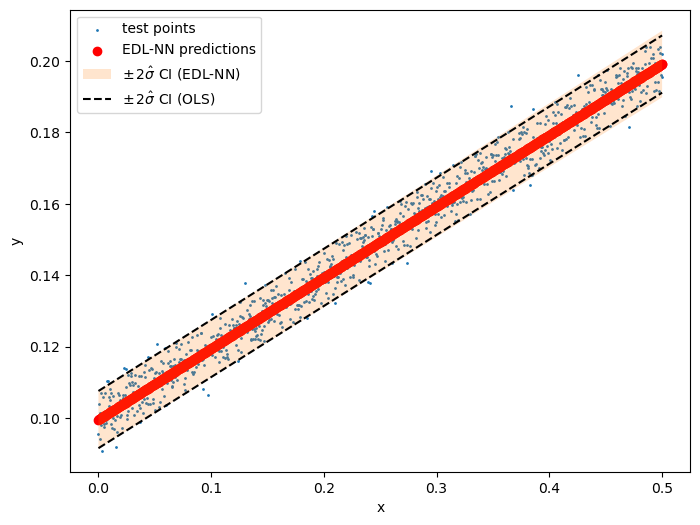

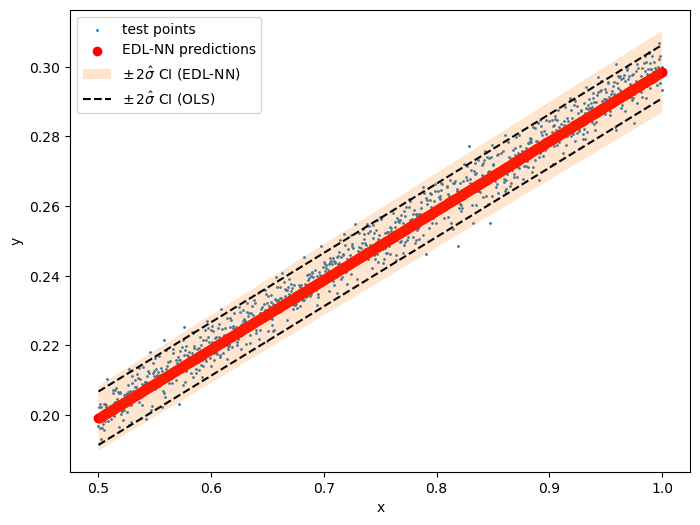

In [4]:
fig = plot_EDL_NN_ci(model, x_train, y_train)
save_xy_graph(fig, "x", "y", figures_dir, 'edl_ci_train.png')
fig = plot_EDL_NN_ci(model, x_test, y_test)
save_xy_graph(fig, "x", "y", figures_dir, 'edl_ci_test.png')

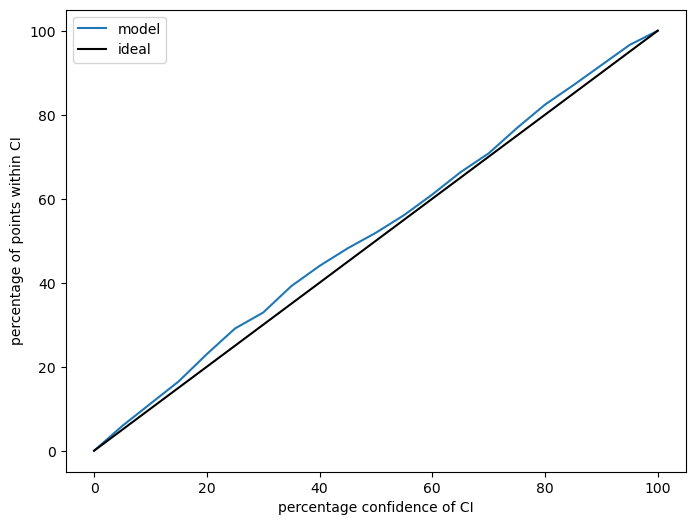

In [5]:
y_hat, sd_hat = get_EDL_NN_output(model, x_train)
in_range = unc_calibration(y_train, y_hat, sd_hat)
fig = plt.figure()
plt.plot(get_confidence_axis(), in_range, label="model")
plt.plot([0,100], [0,100], label="ideal", c="black")
save_xy_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'edl_calibration.png')